In [2]:
# %run simulator.py

import pstats

# Profiling-Ergebnisse aus der .prof-Datei laden
prof_file = "runtime.prof"  # Ersetze durch den Namen deiner .prof-Datei
stats = pstats.Stats(prof_file)

# Ergebnisse sortieren und anzeigen
stats.sort_stats('cumulative')  # Sortieren nach kumulierter Zeit
stats.print_stats(20)  # Zeigt die Top 10 Funktionen

# Alternativ nach Zeit pro Funktion sortieren
stats.sort_stats('time')
stats.print_stats(20)



Thu Dec 12 00:27:03 2024    runtime.prof

         10553 function calls (10143 primitive calls) in 120.380 seconds

   Ordered by: cumulative time
   List reduced from 864 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.008    0.004  120.373  120.373 C:\Users\uhewm\OneDrive\PhD\Project No.2\pangenome-gene-transfer-simulation\simulator.py:207(run_simulation)
        1    0.000    0.000  120.362  120.362 C:\Users\uhewm\anaconda3\envs\pangenome-hgt-sim\Lib\concurrent\futures\_base.py:646(__exit__)
        1    0.000    0.000  120.345  120.345 C:\Users\uhewm\anaconda3\envs\pangenome-hgt-sim\Lib\concurrent\futures\process.py:869(shutdown)
    39/38    0.000    0.000  120.345    3.167 C:\Users\uhewm\anaconda3\envs\pangenome-hgt-sim\Lib\threading.py:1153(_wait_for_tstate_lock)
      2/1    0.000    0.000  120.345  120.345 C:\Users\uhewm\anaconda3\envs\pangenome-hgt-sim\Lib\threading.py:1115(join)
     65/4    0.000    0.000

In [32]:
import simulator
import torch
import re
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering

# Read the data:

file = 'simulation_results(3).txt'

hgt_rates, gene_presence_absence_matrices_unfiltered = simulator.read_simulation_results(file)

# Filter out completely lost genes:

gene_presence_absence_matrices = []
for i in range(0,len(gene_presence_absence_matrices_unfiltered)):
    #gene_presence_absence_matrices.append(np.array([row for row in gene_presence_absence_matrices_unfiltered[i] if not (np.all(row == 0))]))
    gene_presence_absence_matrices.append(np.array([row for row in gene_presence_absence_matrices_unfiltered[i] if not (np.all(row == 0) or np.all(row == 1))]))




In [86]:
def reorder_matrix(matrix):
    """
    Reorders the rows and columns of the matrix based on Hamming distance,
    with each row normalized by dividing by its maximum value before comparison.
    """
    # Compute Hamming distance between columns
    column_hamming_distances = pdist(matrix.T, metric='hamming')  # Transpose to compare columns
    
    # Perform hierarchical clustering for columns
    column_linkage_matrix = linkage(column_hamming_distances, method='average', optimal_ordering = True)  # Average linkage clustering
    
    # Get the optimal order of columns
    column_order = leaves_list(column_linkage_matrix)
    
    # Reorder the columns based on the new order
    matrix = matrix[:, column_order]

    # Normalize rows after column reordering
    #row_maxes = matrix.max(axis=1, keepdims=True)
    #normalized_matrix = matrix / np.maximum(row_maxes, 1e-8)  # Avoid division by zero
    
    # Compute Hamming distance between rows
    row_hamming_distances = pdist(matrix, metric='cosine')  # Compare normalized rows
    
    # Perform hierarchical clustering for rows
    row_linkage_matrix = linkage(row_hamming_distances, method='average', optimal_ordering = True)  # Average linkage clustering
    
    # Get the optimal order of rows
    row_order = leaves_list(row_linkage_matrix)
    
    # Step 10: Reorder the rows based on the new order
    reordered_matrix = matrix[row_order, :]
    
    return reordered_matrix

def custom_distance(matrix):
    """
    Computes a custom distance matrix for rows in the matrix.
    Distance = distance / (Sum of 1s in both rows).
    
    Args:
    - matrix (numpy.ndarray): Input matrix
    
    Returns:
    - numpy.ndarray: Custom distance matrix (condensed form)
    """
    num_rows = matrix.shape[0]
    distance_matrix = []
    
    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            # Calculate distance
            dist = np.sum(abs(matrix[i] - matrix[j]))
            # Calculate the sum of 1s in both rows
            sum_of_ones = np.sum(matrix[i]) + np.sum(matrix[j])
            # Compute custom distance
            distance = dist / sum_of_ones if sum_of_ones != 0 else np.inf
            distance_matrix.append(distance)
    
    return np.array(distance_matrix)

def cluster_and_sum_rows(matrix, num_clusters):
    """
    Clusters the rows of a matrix based on a custom distance and sums the rows within each cluster.
    
    Args:
    - matrix (numpy.ndarray): Input matrix
    - num_clusters (int): Number of clusters to create
    
    Returns:
    - summed_clusters (numpy.ndarray): Summed rows for each cluster
    - labels (list): Cluster labels for each row
    """
    # Step 1: Compute custom distance matrix
    custom_distances = custom_distance(matrix)
    
    # Step 2: Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='complete'
    )
    clustering_model.fit(squareform(custom_distances))
    labels = clustering_model.labels_
    
    # Step 3: Sum rows within each cluster
    summed_clusters = []
    for cluster_id in range(num_clusters):
        # Select rows belonging to the current cluster
        cluster_rows = matrix[labels == cluster_id]
        # Compute the sum of the rows in this cluster
        summed_clusters.append(cluster_rows.sum(axis=0))
    
    return np.array(summed_clusters)

# Specify the number of clusters
num_clusters = min(np.unique(matrix, axis=0).shape[0] for matrix in gene_presence_absence_matrices)
print(num_clusters)

output_file = 'clustered_simulated_data.txt'

ordered_gene_presence_absence_matrices = []
with open(output_file, 'w') as file_handle:
    np.set_printoptions(threshold=np.inf, linewidth=np.inf)
    ordered_gene_presence_absence_matrices = []
    for i in range(0,len(gene_presence_absence_matrices)):
        summed_clusters = reorder_matrix(cluster_and_sum_rows(gene_presence_absence_matrices[i], num_clusters))
        ordered_gene_presence_absence_matrices.append(summed_clusters)
        file_handle.write(f"{summed_clusters}\n")
        if i % 10 == 0:
            print(round(i * 1000 / len(gene_presence_absence_matrices)/10) , "percent clustering done")

simulated_data = [torch.tensor(matrix, dtype=torch.float32) for matrix in ordered_gene_presence_absence_matrices]

if all(isinstance(t, torch.Tensor) for t in simulated_data):
    try:
        # Stack tensors along a new dimension
        simulated_data = torch.stack(simulated_data, dim=0)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        simulated_data = torch.cat(simulated_data, dim=0)

hgt_rates_simulations = torch.tensor(hgt_rates)
hgt_rates_simulations = hgt_rates_simulations.view(-1, 1)  # Umformung zu einer Batch-Dimension


83
0 percent clustering done
2 percent clustering done
4 percent clustering done
6 percent clustering done
8 percent clustering done
10 percent clustering done
12 percent clustering done
14 percent clustering done
16 percent clustering done
18 percent clustering done
20 percent clustering done
22 percent clustering done
24 percent clustering done
26 percent clustering done
28 percent clustering done
30 percent clustering done
32 percent clustering done
34 percent clustering done
36 percent clustering done
38 percent clustering done
40 percent clustering done
42 percent clustering done
44 percent clustering done
46 percent clustering done
48 percent clustering done
50 percent clustering done
52 percent clustering done
54 percent clustering done
56 percent clustering done
58 percent clustering done
60 percent clustering done
62 percent clustering done
64 percent clustering done
66 percent clustering done
68 percent clustering done
70 percent clustering done
72 percent clustering done
74 

In [52]:
def read_clustered_results(file_path):
    results = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        result_start = line

        array_lines = [result_start.strip()]
        i += 1
        while i < len(lines) and not lines[i].strip().startswith("[["):
            array_lines.append(lines[i].strip())
            i += 1

        # Kombiniere und formatiere die Array-Zeilen
        array_text = " ".join(array_lines)
        array_text = re.sub(r'\s+', ',', array_text)  # Ersetzt beliebig viele Leerzeichen durch ein Komma
        array_text = array_text.replace("[,", "[").replace(",]", "]")  # Korrekt formatieren

        # Konvertiere in ein Numpy-Array
        result = np.array(eval(array_text))
        
        # Ergebnisse speichern
        results.append(result)

    return results

clustered_simulated_data = read_clustered_results("clustered_simulated_data.txt")

simulated_data = [torch.tensor(matrix, dtype=torch.float32) for matrix in clustered_simulated_data]

if all(isinstance(t, torch.Tensor) for t in simulated_data):
    try:
        # Stack tensors along a new dimension
        simulated_data = torch.stack(simulated_data, dim=0)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        simulated_data = torch.cat(simulated_data, dim=0)

hgt_rates_simulations = torch.tensor(hgt_rates)
hgt_rates_simulations = hgt_rates_simulations.view(-1, 1)  # Umformung zu einer Batch-Dimension

1


In [80]:
import torch.nn as nn
from sbi import utils
from sbi.neural_nets import posterior_nn
import torch.nn.functional as F
from sbi.inference import SNPE

out_channels = 30
num_samples = len(clustered_simulated_data[0][0])
num_clusters = len(clustered_simulated_data[0])
kernel_size_conv = 6
padding = 0

class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Angepasster Convolutional Layer mit einem anderen Kernel-Size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size_conv, padding=padding)
        # Maxpool-Schicht mit angepasstem Kernel
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        # Fully connected Layer
        self.fc = nn.Linear(in_features=out_channels * (num_clusters-kernel_size_conv) * (num_samples-kernel_size_conv), out_features=1)
        
    def forward(self, x):
        x = x.view(-1, 1, num_clusters, num_samples)
        #print(f"Input size: {x.size()}")
        x = self.pool(F.sigmoid(self.conv1(x)))  # Convolution + sigmoid + Pooling
        #print(f"Size after conv and pooling: {x.size()}")
        x = x.view(-1, out_channels * (num_clusters-kernel_size_conv) * (num_samples-kernel_size_conv))  # Flatten nach Pooling-Schicht
        #print(f"Size after flattening: {x.size()}")
        x = F.sigmoid(self.fc(x))  # Fully connected Layer
        #print(f"Size after fully connected: {x.size()}")
        return x




embedding_net = SummaryNet()

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(density_estimator=neural_posterior)

density_estimator = inference.append_simulations(hgt_rates_simulations, simulated_data).train()
posterior = inference.build_posterior(density_estimator)



C:\Users\uhewm\AppData\Local\Temp\ipykernel_3668\4140260034.py:40: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  neural_posterior = utils.posterior_nn(


 Neural network successfully converged after 62 epochs.

In [50]:
torch.tensor(np.array(clustered_simulated_data))

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 4., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0., ..., 0., 0., 5.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., 36.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([0.0851])


C:\Users\uhewm\AppData\Local\Temp\ipykernel_3668\1065265255.py:11: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  pairplot(samples, points=[hgt_rate_test], points_colors=['r'] )


(<Figure size 1000x1000 with 1 Axes>,
 array([[<Axes: xlabel='dim 1'>]], dtype=object))

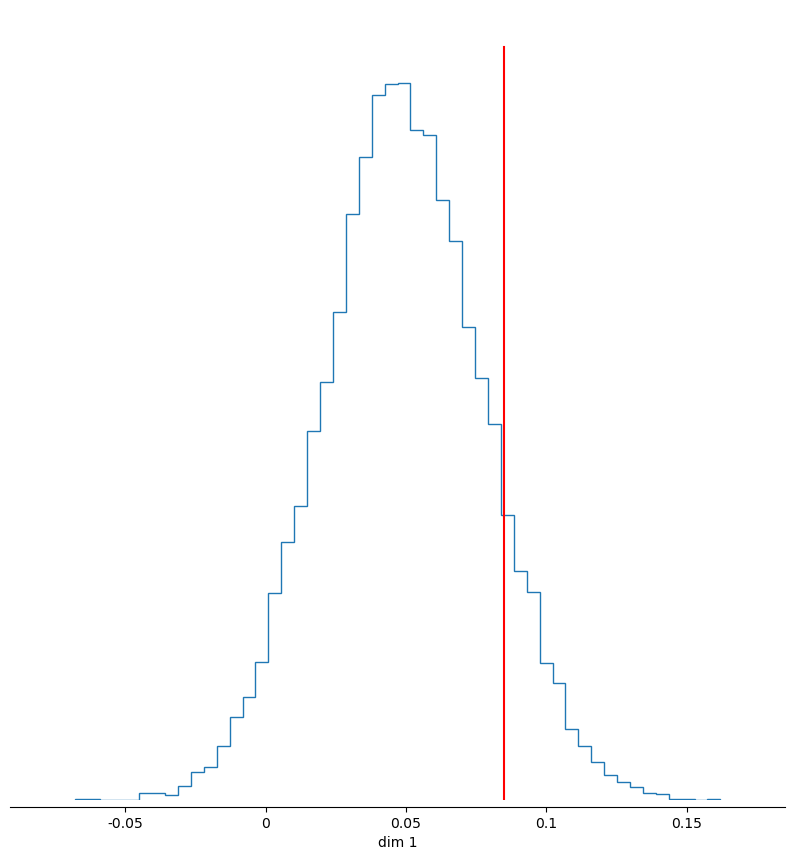

In [82]:
import random
from sbi.analysis import pairplot

z = random.randint(0, 499)
hgt_rate_test = hgt_rates_simulations[z]
x_test = simulated_data[z]

samples = posterior.sample((10000,), x=x_test)

print(hgt_rate_test)
pairplot(samples, points=[hgt_rate_test], points_colors=['r'] )


In [94]:
hgt_rates_simulations = hgt_rates_simulations.view(-1, 1)  # Umformung zu einer Batch-Dimension
